In [1]:
import sys
import os

# Add the project root directory to Python path
sys.path.insert(0, os.path.abspath(".."))

from init_env import set_source_root
project_root = set_source_root()
os.chdir(project_root)

# Setting random seed for reproducibility
import torch
torch.manual_seed(42)

In [2]:
# Load Models
from src.models.gemma_loader import load_gemma
from src.steering.unembedding_steering import steer_generation

model, tokenizer = load_gemma(model_name="google/gemma-2-2b")

/home/hvand/projects/unembedding-steering-benchmark/venv/lib/python3.12/site-packages/transformers/models/auto/tokenization_auto.py:862: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/home/hvand/projects/unembedding-steering-benchmark/venv/lib/python3.12/site-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
def generate_text(model, tokenizer, prompt, max_length=100):

    torch.manual_seed(42)
    # Tokenize
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    # Generate
    output = model.generate(
        inputs.input_ids,
        max_new_tokens=max_length,
        do_sample=True,
        temperature=0.7,
    )
    
    # Decode
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

# CAA Vectors

In [54]:
tensor = torch.load("src/steering/perp_sentiment_linear_probes.pth")

/tmp/ipykernel_95366/25308939.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load("src/steering/perp_sentiment_linear_probes.pth")


In [61]:
l = 21
sf = 0.3
# Get steering vector
steering_vector = tensor[l, 0, :].unsqueeze(0).to("cuda")
# Normalize the steering vector
steering_vector /= torch.norm(steering_vector)

with torch.no_grad():
    # Hook the model, scaling by multiple of residual stream norm
    def hook(module, input, output):
        residual_stream_norm = torch.norm(output[0][:, -1])
        output[0][:, -1] += sf * residual_stream_norm * steering_vector
        return output[0],

    # Register a forward hook on the specified layer
    curr_hook = model.model.layers[l].register_forward_hook(hook)

    # Generate text
    print(generate_text(model, tokenizer, "I hate", max_length=50))

    # Unhook the model
    curr_hook.remove()

I hate the idea of a 4 year old being 5. I don't think it makes sense.

My husband and I are discussing this also. We are pregnant and I hate the idea of a 4 year old being 5.




# Visualizing Unembedding Gridsearch

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plotGridSearch(df, title):
    # 1) Load your CSV of results
    
    #    columns: ["layer", "scale", "avg_score"]

    # 2) Pivot into a matrix
    pivot = df.pivot(index="layer", columns="scale", values="avg_score")
    layers = pivot.index.values
    scales = pivot.columns.values
    scores = pivot.values  # shape (n_layers, n_scales)

    # 3) Plot
    plt.figure(figsize=(8, 6))
    # imshow wants rows→y and cols→x
    im = plt.imshow(scores, 
                    aspect='auto',       # stretch to fill
                    origin='lower',
                    vmin=0,
                    vmax=7)      # so layer 0 is at the bottom

    # 4) Labels and ticks
    plt.xticks(ticks=np.arange(len(scales)), labels=[f"{s:.1f}" for s in scales])
    plt.yticks(ticks=np.arange(len(layers)), labels=layers)
    plt.xlabel("Scale factor")
    plt.ylabel("Layer index")
    plt.title(title)

    # 5) Colorbar
    cbar = plt.colorbar(im)
    cbar.set_label("Avg log‑prob(A) − log‑prob(B)")

    plt.tight_layout()
    plt.show()

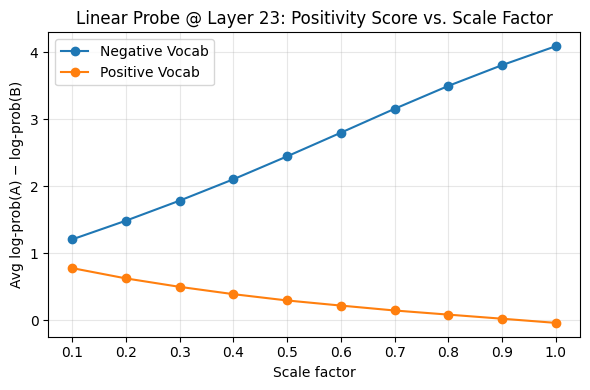

In [29]:
layer_idx = 23

df_0 = pd.read_csv("linear_0_grid_search_results.csv")
df_1 = pd.read_csv("linear_1_grid_search_results.csv")

sub_0 = df_0[df_0["layer"] == layer_idx].sort_values("scale")
scales_0 = sub_0["scale"].values
scores_0 = sub_0["avg_score"].values

sub_1 = df_1[df_1["layer"] == layer_idx].sort_values("scale")
scales_1 = sub_1["scale"].values
scores_1 = sub_1["avg_score"].values

# 2) Make the plot
plt.figure(figsize=(6, 4))
plt.plot(scales_0, scores_0, marker='o', linestyle='-', label='Negative Vocab')
plt.plot(scales_1, scores_1, marker='o', linestyle='-', label='Positive Vocab')
plt.title(f"Linear Probe @ Layer {layer_idx}: Positivity Score vs. Scale Factor")
plt.xlabel("Scale factor")
plt.ylabel("Avg log‑prob(A) − log‑prob(B)")
plt.xticks(scales_0)             # ensure ticks at each scale
plt.grid(alpha=0.3)            # optional, adds light grid
plt.legend()
plt.tight_layout()
plt.show()

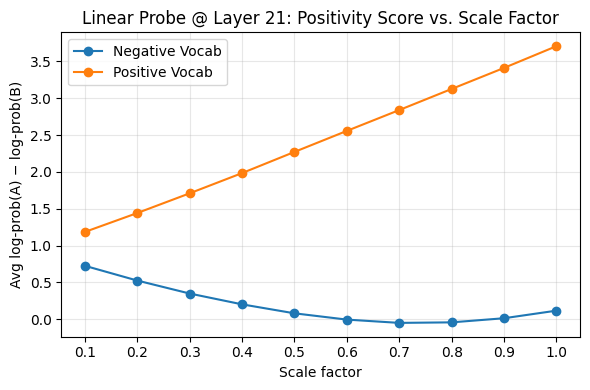

In [28]:
layer_idx = 21

df_0 = pd.read_csv("linear_0_grid_search_results.csv")
df_1 = pd.read_csv("linear_1_grid_search_results.csv")

sub_0 = df_0[df_0["layer"] == layer_idx].sort_values("scale")
scales_0 = sub_0["scale"].values
scores_0 = sub_0["avg_score"].values

sub_1 = df_1[df_1["layer"] == layer_idx].sort_values("scale")
scales_1 = sub_1["scale"].values
scores_1 = sub_1["avg_score"].values

# 2) Make the plot
plt.figure(figsize=(6, 4))
plt.plot(scales_0, scores_0, marker='o', linestyle='-', label='Negative Vocab')
plt.plot(scales_1, scores_1, marker='o', linestyle='-', label='Positive Vocab')
plt.title(f"Linear Probe @ Layer {layer_idx}: Positivity Score vs. Scale Factor")
plt.xlabel("Scale factor")
plt.ylabel("Avg log‑prob(A) − log‑prob(B)")
plt.xticks(scales_0)             # ensure ticks at each scale
plt.grid(alpha=0.3)            # optional, adds light grid
plt.legend()
plt.tight_layout()
plt.show()

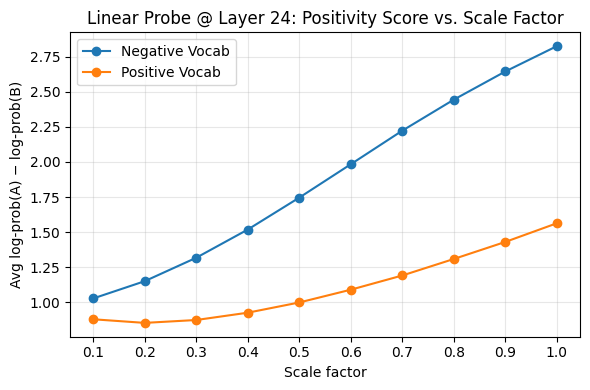

In [34]:
layer_idx = 24

df_0 = pd.read_csv("linear_0_grid_search_results.csv")
df_1 = pd.read_csv("linear_1_grid_search_results.csv")

sub_0 = df_0[df_0["layer"] == layer_idx].sort_values("scale")
scales_0 = sub_0["scale"].values
scores_0 = sub_0["avg_score"].values

sub_1 = df_1[df_1["layer"] == layer_idx].sort_values("scale")
scales_1 = sub_1["scale"].values
scores_1 = sub_1["avg_score"].values

# 2) Make the plot
plt.figure(figsize=(6, 4))
plt.plot(scales_0, scores_0, marker='o', linestyle='-', label='Negative Vocab')
plt.plot(scales_1, scores_1, marker='o', linestyle='-', label='Positive Vocab')
plt.title(f"Linear Probe @ Layer {layer_idx}: Positivity Score vs. Scale Factor")
plt.xlabel("Scale factor")
plt.ylabel("Avg log‑prob(A) − log‑prob(B)")
plt.xticks(scales_0)             # ensure ticks at each scale
plt.grid(alpha=0.3)            # optional, adds light grid
plt.legend()
plt.tight_layout()
plt.show()

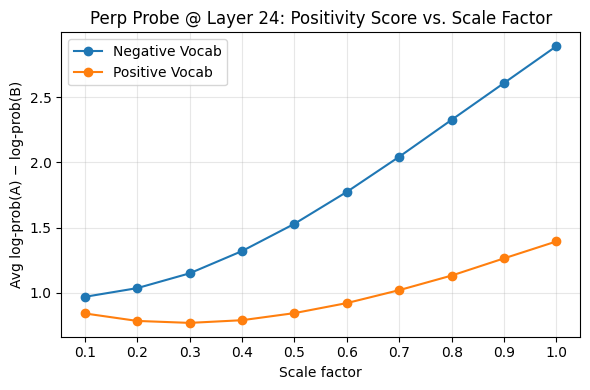

In [30]:
layer_idx = 24

df_0 = pd.read_csv("perp_0_grid_search_results.csv")
df_1 = pd.read_csv("perp_1_grid_search_results.csv")

sub_0 = df_0[df_0["layer"] == layer_idx].sort_values("scale")
scales_0 = sub_0["scale"].values
scores_0 = sub_0["avg_score"].values

sub_1 = df_1[df_1["layer"] == layer_idx].sort_values("scale")
scales_1 = sub_1["scale"].values
scores_1 = sub_1["avg_score"].values

# 2) Make the plot
plt.figure(figsize=(6, 4))
plt.plot(scales_0, scores_0, marker='o', linestyle='-', label='Negative Vocab')
plt.plot(scales_1, scores_1, marker='o', linestyle='-', label='Positive Vocab')
plt.title(f"Perp Probe @ Layer {layer_idx}: Positivity Score vs. Scale Factor")
plt.xlabel("Scale factor")
plt.ylabel("Avg log‑prob(A) − log‑prob(B)")
plt.xticks(scales_0)             # ensure ticks at each scale
plt.grid(alpha=0.3)            # optional, adds light grid
plt.legend()
plt.tight_layout()
plt.show()

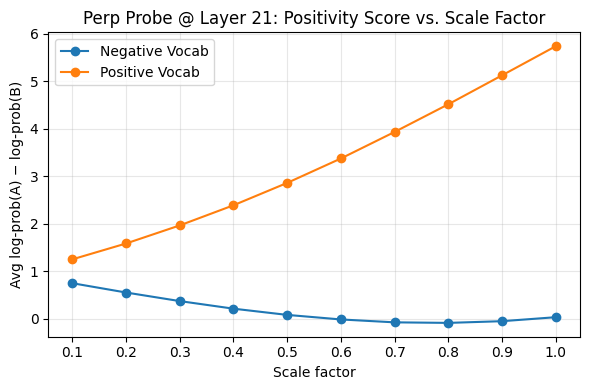

In [32]:
layer_idx = 21

df_0 = pd.read_csv("perp_0_grid_search_results.csv")
df_1 = pd.read_csv("perp_1_grid_search_results.csv")

sub_0 = df_0[df_0["layer"] == layer_idx].sort_values("scale")
scales_0 = sub_0["scale"].values
scores_0 = sub_0["avg_score"].values

sub_1 = df_1[df_1["layer"] == layer_idx].sort_values("scale")
scales_1 = sub_1["scale"].values
scores_1 = sub_1["avg_score"].values

# 2) Make the plot
plt.figure(figsize=(6, 4))
plt.plot(scales_0, scores_0, marker='o', linestyle='-', label='Negative Vocab')
plt.plot(scales_1, scores_1, marker='o', linestyle='-', label='Positive Vocab')
plt.title(f"Perp Probe @ Layer {layer_idx}: Positivity Score vs. Scale Factor")
plt.xlabel("Scale factor")
plt.ylabel("Avg log‑prob(A) − log‑prob(B)")
plt.xticks(scales_0)             # ensure ticks at each scale
plt.grid(alpha=0.3)            # optional, adds light grid
plt.legend()
plt.tight_layout()
plt.show()

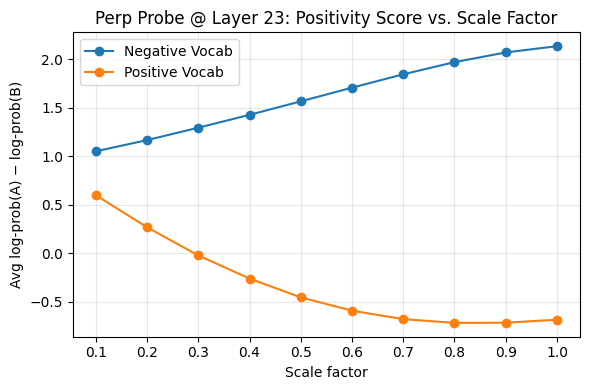

In [33]:
layer_idx = 23

df_0 = pd.read_csv("perp_0_grid_search_results.csv")
df_1 = pd.read_csv("perp_1_grid_search_results.csv")

sub_0 = df_0[df_0["layer"] == layer_idx].sort_values("scale")
scales_0 = sub_0["scale"].values
scores_0 = sub_0["avg_score"].values

sub_1 = df_1[df_1["layer"] == layer_idx].sort_values("scale")
scales_1 = sub_1["scale"].values
scores_1 = sub_1["avg_score"].values

# 2) Make the plot
plt.figure(figsize=(6, 4))
plt.plot(scales_0, scores_0, marker='o', linestyle='-', label='Negative Vocab')
plt.plot(scales_1, scores_1, marker='o', linestyle='-', label='Positive Vocab')
plt.title(f"Perp Probe @ Layer {layer_idx}: Positivity Score vs. Scale Factor")
plt.xlabel("Scale factor")
plt.ylabel("Avg log‑prob(A) − log‑prob(B)")
plt.xticks(scales_0)             # ensure ticks at each scale
plt.grid(alpha=0.3)            # optional, adds light grid
plt.legend()
plt.tight_layout()
plt.show()

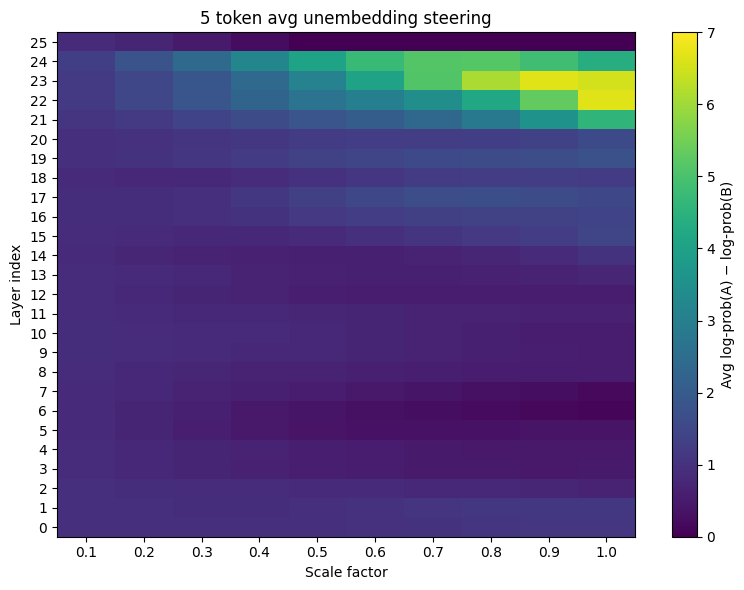

In [ ]:
df = pd.read_csv("grid_search_results.csv")
plotGridSearch(df, "5 token avg unembedding steering")


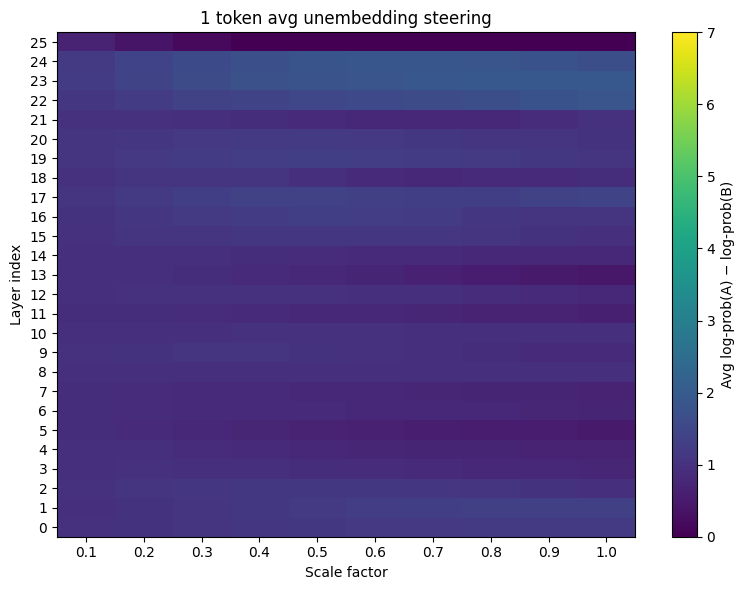

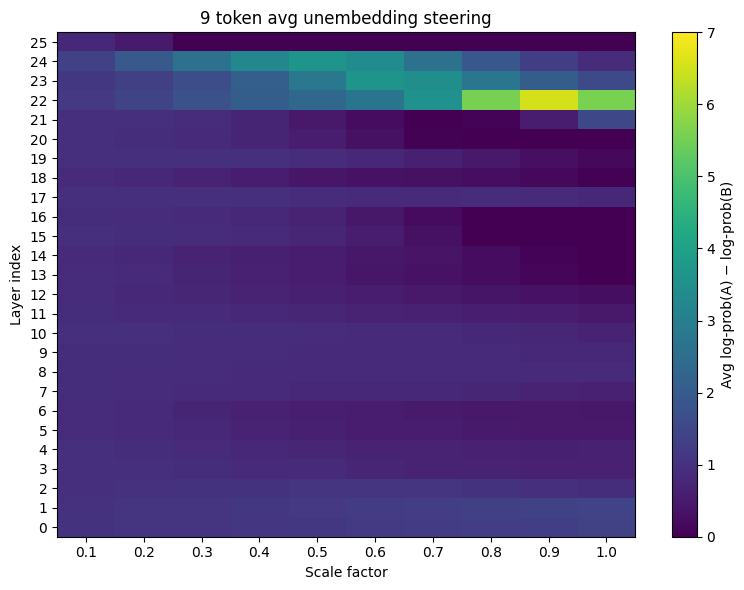

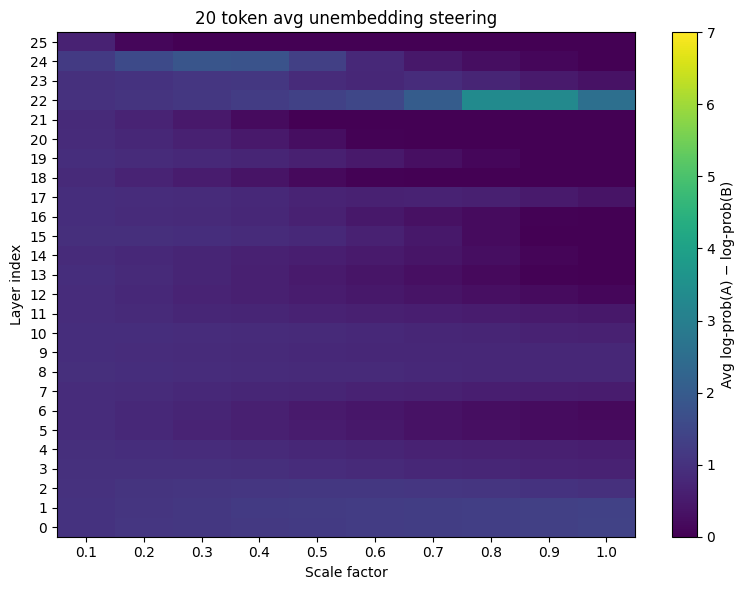

In [7]:
for i in [1, 9, 20]:
    df = pd.read_csv(f"{i}_grid_search_results.csv")
    plotGridSearch(df, f"{i} token avg unembedding steering")

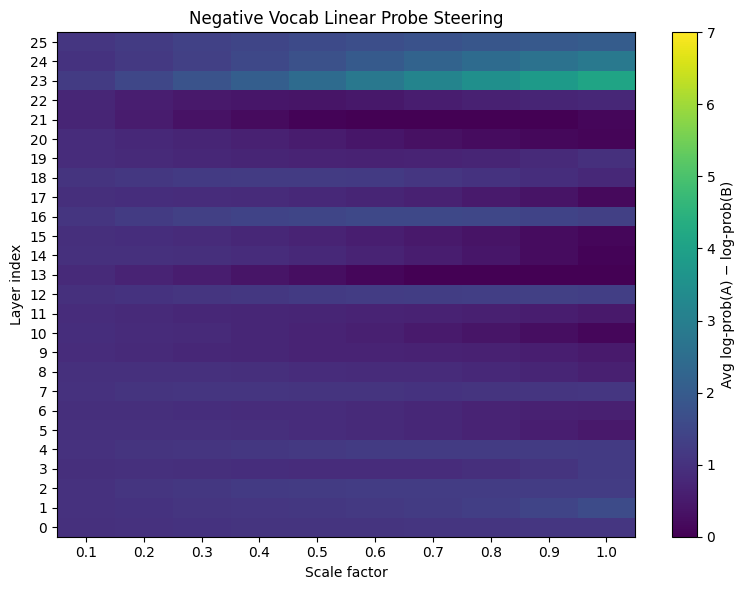

In [8]:
df = pd.read_csv("linear_0_grid_search_results.csv")
plotGridSearch(df, "Negative Vocab Linear Probe Steering")

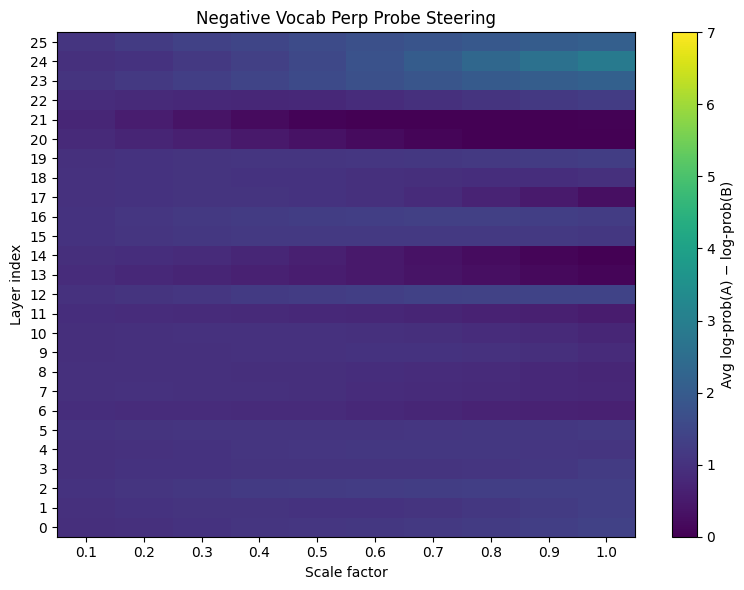

In [9]:
df = pd.read_csv("perp_0_grid_search_results.csv")
plotGridSearch(df, "Negative Vocab Perp Probe Steering")

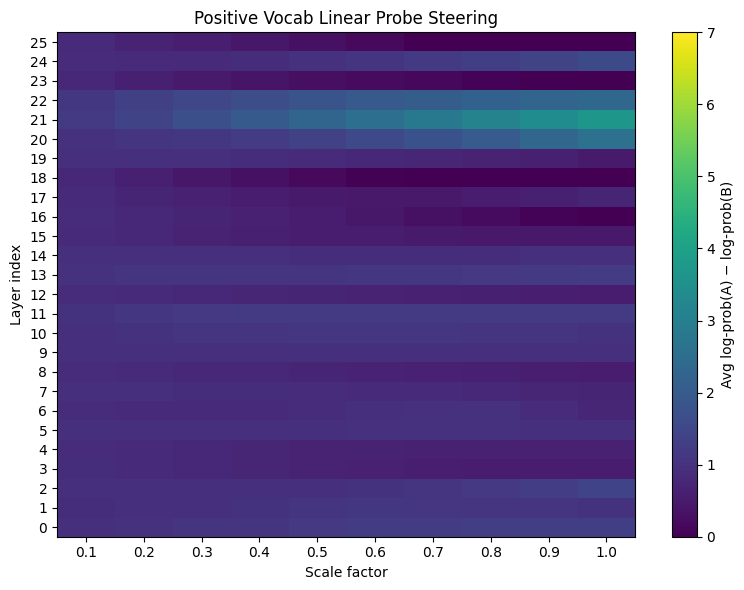

In [10]:
df = pd.read_csv("linear_1_grid_search_results.csv")
plotGridSearch(df, "Positive Vocab Linear Probe Steering")

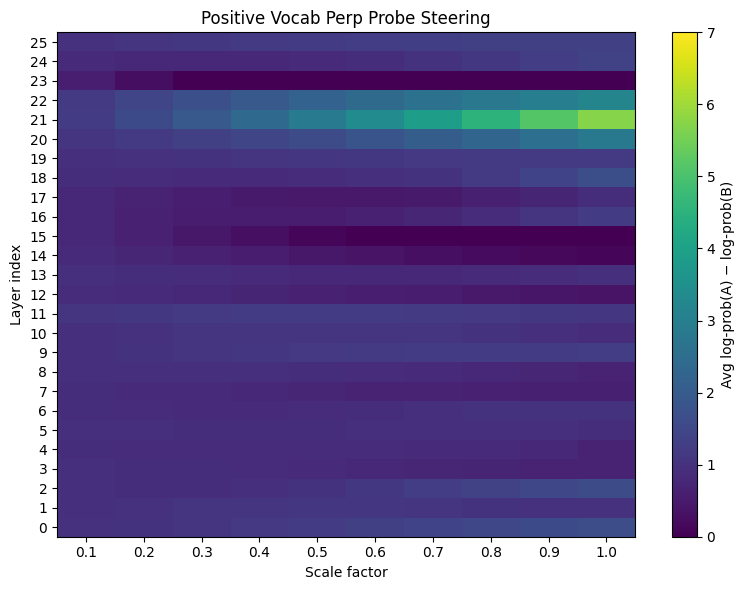

In [11]:
df = pd.read_csv("perp_1_grid_search_results.csv")
plotGridSearch(df, "Positive Vocab Perp Probe Steering")

# Early Analysis (Midterm Report)

In [36]:
output = steer_generation(model=model, tokenizer=tokenizer, prompt="I hate", steering_tokens=steering_tokens, layer=20, scaling_factor=60)
print(output)

I hate the idea of a great company being ruined by 1 lousy employee.

I am a big fan of the company, and the great people that work there. But I hate the idea of ruining my time with such a great company by staying with an awful employee.

I am a loyal customer, and always buy the best version of the product. But I hate having this product ruined by amazing customer service.

I am going through an awful situation with a phone I ordered from them. It has


In [35]:
steering_tokens = [" happy", " amazing", " splendid", " incredible"]

for i in [5,10,15,25]:
    output = steer_generation(model=model, tokenizer=tokenizer, prompt="I hate", steering_tokens=steering_tokens, layer=i, scaling_factor=60)
    print(i, output)

5 I hate the smell of fresh coffee.
I don’t know how you can be at this time of year and have such a great life.

I love your blog.
My daughter is 18 months old and she is amazing.
I love how you have your life together with your husband and beautiful little one.
I can’t wait to share this amazing life with you.
I am so happy for you.
I wish you a wonderful birthday.
I am so excited
10 I hate the idea of a great company going under. <strong>In a nutshell, this is what makes us fall in love with the story of <u><strong>The Man Company</strong></u>:</strong>

* It's been around since 2016, when two friends started this brand with a mission to make men look and feel great.
* They started off as a small, bootstrapped team, but today they have managed to hire a team of 250+ amazing people who have
15 I hate the idea of a great company going down in flames. But what an incredible company, what a legend.

One of the greatest companies to ever exist has been sold for over £1 billion and it's u

In [10]:
output=generate_text(model=model, tokenizer=tokenizer, prompt="I hate")
print(output)

I hate the idea of a holiday.
I don’t hate the idea of a break, but holiday is a holiday, and I don’t like holidays.
I don’t want to be told what to do.
I don’t want to be told what to think.
I don’t want to be told what to feel.

Holiday is a time when I am expected to be happy.
I am supposed to be happy because it’s a holiday.
I


In [41]:
steering_tokens = [" happy"]
# " amazing", " splendid", " incredible", " joyful"
# " delighted", " excited", " thrilled", " ecstatic", " overjoyed", 
# " euphoric", " jubilant", " blissful", " cheerful", " content"
#" satisfied", " pleased", " gratified", " fulfilled", " fabulous"

output = steer_generation(model=model, tokenizer=tokenizer, prompt="I hate", steering_tokens=steering_tokens, layer=15, scaling_factor=60)
print(output)

I hate the idea of a holiday.
I don’t want a holiday, I want a life. I want my life to be great. I want people to be happy and I want to be happy.

I’m not really sure what I believe anymore but I know I don’t want to get fat.

I have a very happy, very content life, but I’m not sure I can make it work for as long as I want to.

I’m not sure


In [ ]:
prmpt = "The worst thing is"
lyr = 15
steering_tokens = [" happy", " amazing", " splendid", " incredible"]

print(f"SF = 20")
output = steer_generation(model=model, tokenizer=tokenizer, prompt=prmpt, steering_tokens=steering_tokens, layer=lyr, scaling_factor=20)
print(output)

print(f"SF = 30")
output = steer_generation(model=model, tokenizer=tokenizer, prompt=prmpt, steering_tokens=steering_tokens, layer=lyr, scaling_factor=20)
print(output)

print(f"SF = 40")
output = steer_generation(model=model, tokenizer=tokenizer, prompt=prmpt, steering_tokens=steering_tokens, layer=lyr, scaling_factor=20)
print(output)

print(f"SF = 50")
output = steer_generation(model=model, tokenizer=tokenizer, prompt=prmpt, steering_tokens=steering_tokens, layer=lyr, scaling_factor=50)
print(output)

print("No steering:")
output=generate_text(model=model, tokenizer=tokenizer, prompt=prmpt)
print(output)

SF = 20
The worst thing is that, in spite of the fact that the <strong><em>new</em></strong> <strong><em>Mercedes-Benz C-Class</em></strong> is built on a <strong><em>new</em></strong> <strong><em>platform</em></strong>, it still looks like an <em>old</em> <em>car</em>.

The <em>C-Class</em> has been around since 1993, and the looks haven’t changed all that much.

I’m not saying that I’m a fan of the
SF = 50
The worst thing is that, in spite of the fact that the <strong>wonderful</strong> <strong>world</strong> of <strong>anime</strong>, <strong>manga</strong> and <strong>Japanese culture</strong> in general, is a <strong>wonderful world</strong> that makes us dream every day, sometimes we have to face some <strong>tragic</strong> <strong>stories</strong>.

But today we are not going to talk to you about amazing stories, but about the best way to <strong>celebrate</strong> the <strong>life</strong>, the best way
No steering:
The worst thing is that, in spite of the fact that the <stron

In [14]:
output = steer_generation(model=model, tokenizer=tokenizer, prompt=prmpt, steering_tokens=steering_tokens, layer=lyr, scaling_factor=30)
print(output)

The worst thing is that, in spite of the fact that the <strong><em>new</em></strong> <strong><em>Mercedes-Benz C-Class</em></strong> is built on a <strong>fantastically</strong> <strong><em>beautiful</em></strong> <strong>platform</strong>, it is still not an <strong><em>all-round</em></strong> <strong><em>perfect car</em></strong>. We have to admit that the <em><strong>German</strong></em><em> <strong>superb</strong></em> has some minor issues with the <em><strong>suspension</strong></em>, 


In [15]:
steering_tokens = [" faggot", " cocksucker", " twink", " dicksucker"]
output = steer_generation(model=model, tokenizer=tokenizer, prompt="The fitness gram pacer test", steering_tokens=steering_tokens, layer=15, scaling_factor=140)
print(output)


The fitness gram pacer test dates are the worst. I hate them. 100-yard dashes at recess are fun though.
i'm 23, 21 years old and hate doing that ****.

i got a job interview today and i had to take a piss in a cup and swab my knob for the test.

i'm gay as hell though, so i don't give a **** what i do in my dickhole.
I hate doing that shit. I think
